#### Copyright 2020 Connaissance Publishing.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# **Understanding Deep Learning: Application in Rare Event Prediction**

Author: Chitta Ranjan, Ph.D.

[ProcessMiner, Inc.](https://processminer.com)

cranjan@processminer.com

LinkedIn: https://www.linkedin.com/in/chitta-ranjan-b0851911/

Medium: https://medium.com/@cran2367

# Multilayer Perceptron (MLP): Rare Event Binary Classification

A Perceptron was built in 1950s. A Perceptron proved to be a powerful classifier at the time. Researchers soon realized stacking multiple perceptrons could be much more powerful. That turned out to be true and Multilayer Perceptrons came into being.

A Perceptron works like a neuron in a human brain. It takes multiple inputs and, like a neuron emits an electric pulse, the Perceptron emits a binary response. Possibly from here, the term Neural Network was attributed to Multilayer Perceptrons.

Since then, Neural Networks has evolved tremendously with Convolutional, Recurrent and other networks developed over time. Despite all the developments, Multilayer Perceptrons will always keep the _first_ status. And as the first, Multilayer Perceptron and Neural Network are used interchangeably. Or, rather, a loose reference to Neural Network often means a Multilayer Perceptron.

In short, multilayer perceptron is the "hello world" of Deep Learning. And, therefore, a good place to start when you are learning about or developing a new model in Deep Learning.

# Connection

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/My Drive/understanding-deep-learning/codebase'
import os
os.chdir(root_path)

Mounted at /content/gdrive


In [ ]:
os.getcwd()

# Libraries

In [ ]:
get_ipython().magic('matplotlib inline')

%tensorflow_version 2.x
import tensorflow as tf

from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AlphaDropout

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

# user-defined libraries
import utilities.datapreprocessing as dp
import utilities.performancemetrics as pm
import utilities.simpleplots as sp

from numpy.random import seed
seed(1)

from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
print('My tensorflow version, ', tf.__version__)

My tensorflow version,  2.2.0-rc2


# Data Preparation


## Reading and preparing data

In [ ]:
'''
Download data here:
https://docs.google.com/forms/d/e/1FAIpQLSdPCkTFW1wTp6tAP1C1BhT7HWTQ60-GfCGvWs9Ca4WbR0FIdg/viewform
'''
df = pd.read_csv("data/processminer-sheet-break-rare-event-dataset.csv")
df.head(n=5)  # visualize the data.

,DateTime,SheetBreak,RSashScanAvg,CT#1 BLADE PSI,P4 CT#2 BLADE PSI,Bleached GWD Flow,ShwerTemp,BlndStckFloTPD,C1 BW SPREAD CD,RS BW SPREAD CD,C1 BW SPREAD MD,RS BW SPREAD MD,C1 BW SCAN AVG,RS BW SCAN AVG,CoatBrkFlo,Clay Flow,CouchLoVac,COUCH VAC,4PrsTopLd,4PrsBotLod,CalndrDrw,2DryrDrw,3DryrDrw,4DryrDraw,1PrsTopDrw,4PrsBotDrw,FanPmpSpd,FlBxHdrVac,FlatBxVac,Grade&Bwt,UnblGWDFlo,Hdbox pH,HdBxLiqLvl,"TotHead""",HorzSlcPos,KraftFlow,CouchLoad,C1MoSprdCD,RSMoSprdCD,C1MoSprdMD,RSMoSprdMD,RL MoisAct,PrScrRjFlo,RwBrkFlo,RcycFbrFlo,RetnAidFlo,RUSH DRAG,Rush/Drag,SilicaFlo,HBxSlcTemp,SodAlumFlo,CouchSpd,MachSpd,1PrsTopSpd,4PrsBotSpd,WtNStarFlo,BasWgtFlo,TMP Flow,HBxTotHead,TrayCons,UpprHdTmpRL,VertSlcPos,EventPress
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,-0.038189,0.877951,-0.052959,-13.306135,0.101068,0.041800,0.199901,-2.327329,-0.944167,3.075199,0.123154,-0.104334,-0.570710,-9.784456,0.355960,15.842819,-0.451974,-0.105282,96,-134.277862,0.058726,-0.021645,9.366755,0.002151,-69.187583,4.232571,-0.225267,-0.196872,-0.072449,-0.103732,-0.720746,-5.412436,76.679042,-0.632727,1351.632859,-0.657095,-0.434947,-108.775969,0.084856,10.210182,11.295155,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230658,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,-0.038189,0.873273,-0.014244,-13.306135,0.101108,0.041447,0.304313,-2.340627,-0.939994,3.075199,0.123154,-0.104334,-0.574861,-9.784456,0.360160,16.491684,-0.450451,-0.092430,96,-134.480194,0.058759,-0.004579,9.350215,0.002149,-68.585197,4.311490,-0.225267,-0.196872,-0.059103,-0.083895,-0.720746,-8.343222,78.181598,-0.632727,1370.378949,-0.875628,-1.125819,-108.848967,0.085146,12.534340,11.290761,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,-0.018352,1.004910,0.065150,-9.619596,0.101148,0.041095,0.252839,-2.353925,-0.935824,3.075199,0.123154,-0.104334,-0.579013,-9.784456,0.364356,15.972885,-0.448927,-0.097144,96,-133.946587,0.058791,-0.084658,9.037409,0.002148,-67.838187,4.809914,-0.225267,-0.186801,-0.048696,-0.073823,-0.720746,-1.085166,79.684154,-0.632727,1368.123089,-0.037775,-0.519541,-109.086577,0.085436,18.582893,11.286366,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,-0.008280,0.930037,-0.067199,-15.196531,0.101188,0.040742,0.072873,-2.367223,-0.931651,3.075199,0.123154,-0.104334,-0.583165,-9.784456,0.368556,15.608688,-0.447404,-0.160073,96,-134.002586,0.058824,-0.055118,9.020625,0.002146,-67.091148,5.308343,-0.225267,-0.186801,-0.047017,-0.063752,-0.720746,6.172891,81.186702,-0.632727,1365.691449,-0.987410,0.674524,-109.562774,0.085726,17.719032,11.281972,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,-0.008280,0.828410,-0.018472,-14.609266,0.101229,0.040390,0.171033,-2.380521,-0.927478,3.075199,0.123154,-0.104334,-0.587316,-9.784456,0.372756,15.606125,-0.445880,-0.131630,96,-133.145706,0.058856,-0.153851,9.344233,0.002145,-65.991813,5.806771,-0.225267,-0.186801,-0.057088,-0.063752,-0.720746,-3.379599,82.689258,-0.632727,1363.257859,-0.238444,-0.063044,-110.038909,0.086016,16.855202,11.277577,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [ ]:
# Convert Categorical column to hot dummy columns
hotencoding1 = pd.get_dummies(df['Grade&Bwt'])
hotencoding1 = hotencoding1.add_prefix('grade_')
hotencoding2 = pd.get_dummies(df['EventPress'])
hotencoding2 = hotencoding2.add_prefix('eventpress_')

df=df.drop(['Grade&Bwt', 'EventPress'], axis=1)

df=pd.concat([df, hotencoding1, hotencoding2], axis=1)

# Rename response column name for ease of understanding
df=df.rename(columns={'SheetBreak':'y'})

## Shift the data

This is a time series data in which we have to predict the event (y = 1) ahead in time. In this data, consecutive rows are 2 minutes apart. We will shift the labels in column `y` by 2 rows to do a 4 minute ahead prediction.

In [ ]:
# Sort by time.
df['DateTime'] = pd.to_datetime(df.DateTime)
df = df.sort_values(by='DateTime')

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = dp.curve_shift(df, shift_by=-2)

In [ ]:
# Drop the time column.
df = df.drop(['DateTime'], axis=1)

# Converts df to numpy array
X = df.loc[:, df.columns != 'y'].values  
y = df['y'].values

# Axes lengths
N_FEATURES = X.shape[1]

## Divide the data into train, valid, and test

In [ ]:
# Divide the data into train, valid, and test
X_train, X_test, y_train, y_test = train_test_split(np.array(X),
                                                    np.array(y),
                                                    test_size=DATA_SPLIT_PCT,
                                                    random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                      y_train,
                                                      test_size=DATA_SPLIT_PCT,
                                                      random_state=SEED)

In [ ]:
print(X_train.shape[0]/X.shape[0], X_valid.shape[0]/X.shape[0], X_test.shape[0]/X.shape[0])

0.6399645721596221 0.16001574570683463 0.20001968213354326


## Standardize the data
Scale the data before fitting any Neural Network. Since the data (predictors) are unbounded, we will use StandardScaler. It scales the predictors to Gaussian with mean 0 and sd 1.

In [ ]:
# Scaler using the training data.
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train, scaler)
X_valid_scaled = scaler.transform(X_valid, scaler)
X_test_scaled = scaler.transform(X_test, scaler)

# Multilayer Perceptron (MLP) Modeling

## Model 1. Baseline.

In [ ]:
model = Sequential()
model.add(Input(shape=(N_FEATURES, )))

Adding intermediate hidden layers.

In [ ]:
model.add(Dense(32, activation='relu', name='hidden_layer_1'))
model.add(Dense(16, activation='relu', name='hidden_layer_2'))

Now we will add an output layer. The output layer requires a little attention. This layer is designed depending on the response variable. 

- `activation`: In a regression problem, the last layer activation is `linear`. For a classification problem, this is typically `sigmoid`.
- `units`: The number of units is equal to the number of classes in classification and the number of response variables in regression.

In [ ]:
model.add(Dense(1, activation='sigmoid', name='output_layer'))

Look at the model summary.

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 32)                2240      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 16)                528       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 17        
Total params: 2,785
Trainable params: 2,785
Non-trainable params: 0
_________________________________________________________________


Since we have imbalanced data, we have Recall, F1Score, and FalsePositiveRate as the performance metrics.

In addition, the conventional `accuracy` metric is also kept as it helps do a sanity check on the model output. In our unbalanced data, the `accuracy` is expected to be high. If it is not high, we should diagnose the model. For example, if the activation of last layer is changed from `sigmoid` to `softmax`, the accuracy drops to around 1%, which is a clear sign of something wrong.

In [ ]:
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 
                     tf.keras.metrics.Recall(),
                     pm.F1Score(),
                     pm.FalsePositiveRate()]
           )

Now, we are at the stage of training the model.

In [ ]:
history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=100,
                    validation_data=(X_valid_scaled, y_valid),
                    verbose=1).history

Epoch 1/100
102/102 [==============================] - 0s 4ms/step - loss: 0.1706 - accuracy: 0.9689 - recall_1: 0.0585 - f1_score: 0.0472 - false_positive_rate: 0.0189 - val_loss: 0.0706 - val_accuracy: 0.9862 - val_recall_1: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_false_positive_rate: 0.0000e+00
Epoch 2/100
102/102 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.9869 - recall_1: 0.0000e+00 - f1_score: 0.0000e+00 - false_positive_rate: 0.0000e+00 - val_loss: 0.0670 - val_accuracy: 0.9862 - val_recall_1: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_false_positive_rate: 0.0000e+00
Epoch 3/100
102/102 [==============================] - 0s 2ms/step - loss: 0.0664 - accuracy: 0.9869 - recall_1: 0.0000e+00 - f1_score: 0.0000e+00 - false_positive_rate: 0.0000e+00 - val_loss: 0.0656 - val_accuracy: 0.9862 - val_recall_1: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_false_positive_rate: 0.0000e+00
Epoch 4/100
102/102 [==============================] - 0s 2ms/step 

In the above we see the three metrics for both training and validation data. Visually, this is quite verbose. However, it is suggested to be agnostic to the verbosity. If needed, we should add even more metrics. Our purpose is to build the most effective model.

`fit` returns an object `history` that contains the loss and accuracy metrics. They can be then visualized to see the model fitting progress.

### Plotting Model Performance

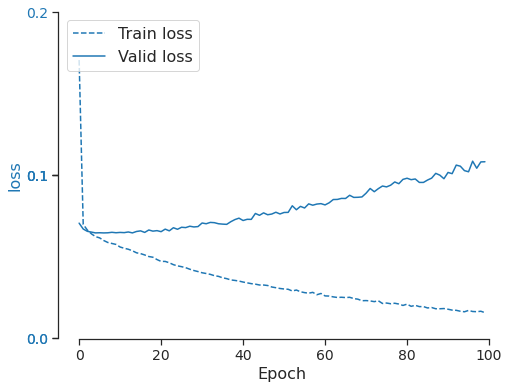

In [ ]:
plt, fig = sp.plot_metric(history, metric='loss')
fig.savefig('mlp_baseline_loss.pdf', bbox_inches='tight')

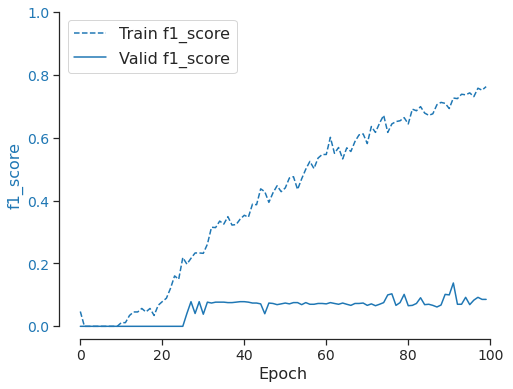

In [ ]:
plt, fig = sp.plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('mlp_baseline_f1_score.pdf', bbox_inches='tight')

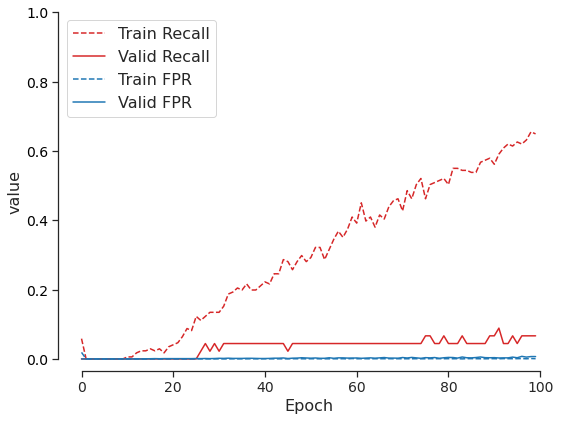

In [ ]:
plt, fig = sp.plot_model_recall_fpr(history)
fig.savefig('mlp_baseline_recall_fpr.pdf', bbox_inches='tight')

## Model 2. Dropout Regularization.

The validation loss in the baseline model was increasing. This is typically due to overfitting. A resolution is adding a Dropout for regularization.

In [ ]:
model = Sequential()
model.add(Input(shape=(N_FEATURES, )))
model.add(Dense(32, activation='relu', name='hidden_layer_1'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', name='hidden_layer_2'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', name='output_layer'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 128)               8960      
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 32)                4128      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 33        
Total params: 13,121
Trainable params: 13,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 
                     tf.keras.metrics.Recall(),
                     pm.F1Score(),
                     pm.FalsePositiveRate()]
           )

In [ ]:
history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=100,
                    validation_data=(X_valid_scaled, y_valid),
                    verbose=0).history

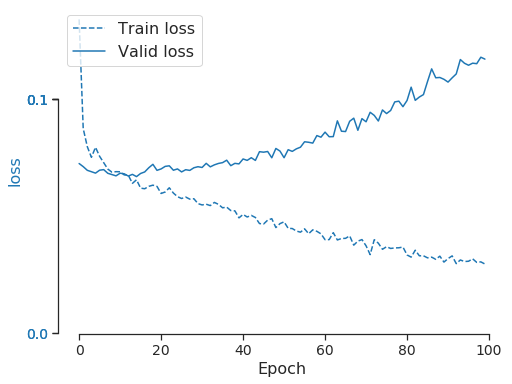

In [ ]:
plt, fig = sp.plot_metric(history, metric='loss')
fig.savefig('mlp_dropout_loss.pdf', bbox_inches='tight')

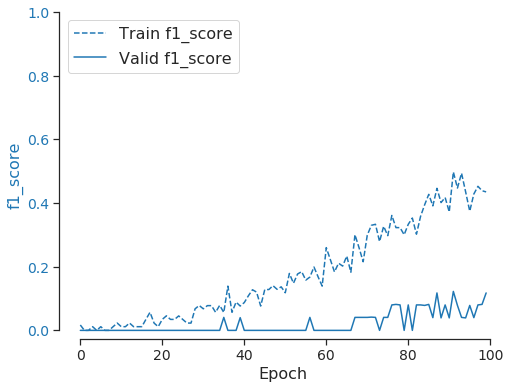

In [ ]:
plt, fig = sp.plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('mlp_dropout_f1score.pdf', bbox_inches='tight')

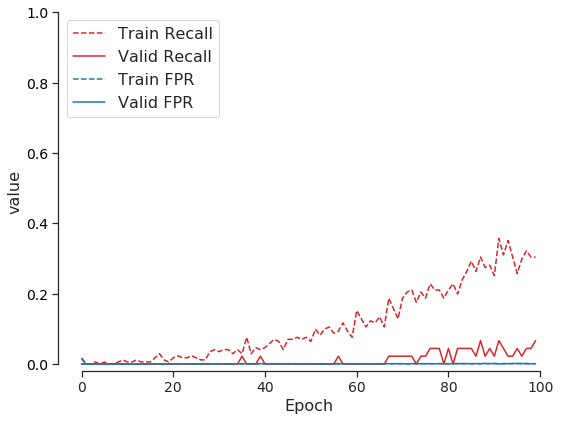

In [ ]:
plt, fig = sp.plot_model_recall_fpr(history)
fig.savefig('mlp_dropout_recall_fpr.pdf', bbox_inches='tight')

Dropout addressed the increasing validation loss but made the performance worse. Therefore, we will not use it here.

## Model 3. Balancing Classes Weights

The rare event problem has very few positive class samples. Due to this, even if the classifier is misclassifying the positive labels, their affect on the loss function is miniscule. Therefore, we sometimes overweight the positives and underweight the negative samples.

Arbitrary weights can be tried. But as a rule of thumb, we start with,

- positive class weight: number of negative samples / total samples.
- negative class weight: number of positive samples / total samples.

In [ ]:
class_weight = {0: sum(y_train == 1)/len(y_train), 1: sum(y_train == 0)/len(y_train)}

In [ ]:
class_weight

{0: 0.01314777794863909, 1: 0.9868522220513609}

In [ ]:
model = Sequential()
model.add(Input(shape=(N_FEATURES, )))
model.add(Dense(32, activation='relu', name='hidden_layer_1'))
model.add(Dense(16, activation='relu', name='hidden_layer_2'))
model.add(Dense(1, activation='sigmoid', name='output_layer'))

model.summary()

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 
                     tf.keras.metrics.Recall(),
                     pm.F1Score(),
                     pm.FalsePositiveRate()]
           )
           
history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=100,
                    validation_data=(X_valid_scaled, y_valid),
                    class_weight=class_weight,
                    verbose=0).history

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 32)                2240      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 16)                528       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 17        
Total params: 2,785
Trainable params: 2,785
Non-trainable params: 0
_________________________________________________________________
  ...
    to  
  ['...']
  ...
    to  
  ['...']


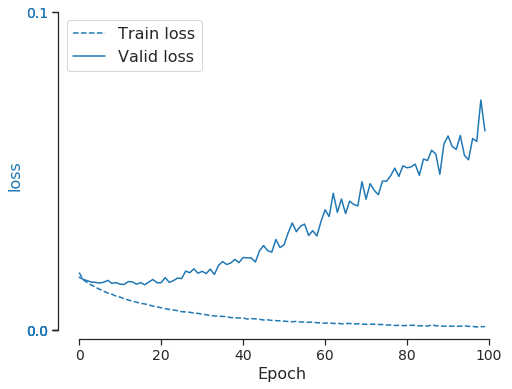

In [ ]:
plt, fig = sp.plot_metric(history, metric='loss')
# fig.savefig('mlp_class_weights_loss.pdf', bbox_inches='tight')

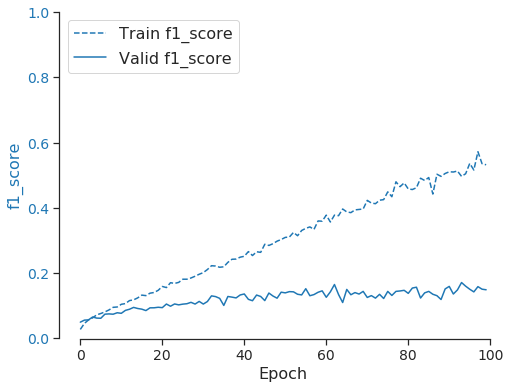

In [ ]:
plt, fig = sp.plot_metric(history, metric='f1_score', ylim=[0., 1.])
# fig.savefig('mlp_class_weights_f1score.pdf', bbox_inches='tight')

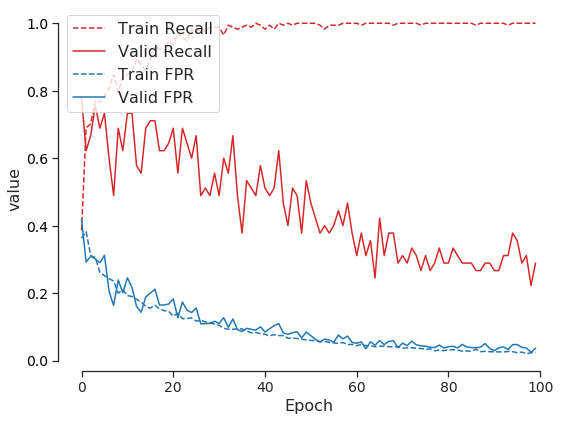

In [ ]:
plt, fig = sp.plot_model_recall_fpr(history)
# fig.savefig('mlp_class_weights_recall_fpr.pdf', bbox_inches='tight')

The weight balancing did slightly improve the validation accuracy.

## Model 4. Oversampling - SMOTE.

There are a number of methods available to oversample a dataset used in a typical classification problem (using a classification algorithm to classify a set of images, given a labelled training set of images). The most common technique is known as SMOTE: Synthetic Minority Over-sampling Technique[4]. 

To illustrate how this technique works consider some training data which has s samples, and f features in the feature space of the data. Note that these features, for simplicity, are continuous. As an example, consider a dataset of birds for classification. The feature space for the minority class for which we want to oversample could be beak length, wingspan, and weight (all continuous). 

To then oversample, take a sample from the dataset, and consider its k nearest neighbors (in feature space). To create a synthetic data point, take the vector between one of those k neighbors, and the current data point. Multiply this vector by a random number x which lies between 0, and 1. Add this to the current data point to create the new, synthetic data point.

In [ ]:
smote = SMOTE(random_state=212, k_neighbors=1)
X_train_scaled_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, 
                                                                 y_train)
print('Resampled dataset shape %s' % Counter(y_train_resampled))

Resampled dataset shape Counter({0.0: 12835, 1.0: 12835})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
model = Sequential()
model.add(Input(shape=(N_FEATURES, )))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 
                     tf.keras.metrics.Recall(),
                     pm.F1Score(),
                     pm.FalsePositiveRate()]
           )

history = model.fit(x=X_train_scaled_resampled,
                    y=y_train_resampled,
                    batch_size=128,
                    epochs=200,
                    validation_data=(X_valid_scaled, y_valid),
                    verbose=0).history

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                2240      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 2,785
Trainable params: 2,785
Non-trainable params: 0
_________________________________________________________________


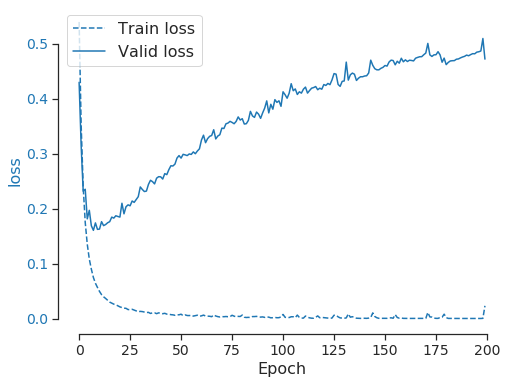

In [ ]:
plt, fig = sp.plot_metric(history, metric='loss')
fig.savefig('mlp_SMOTE_loss.pdf', bbox_inches='tight')

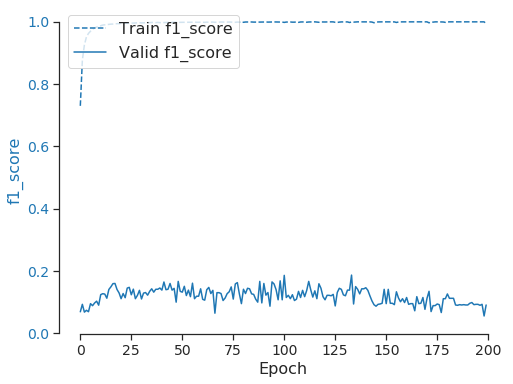

In [ ]:
plt, fig = sp.plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('mlp_SMOTE_weights_f1score.pdf', bbox_inches='tight')

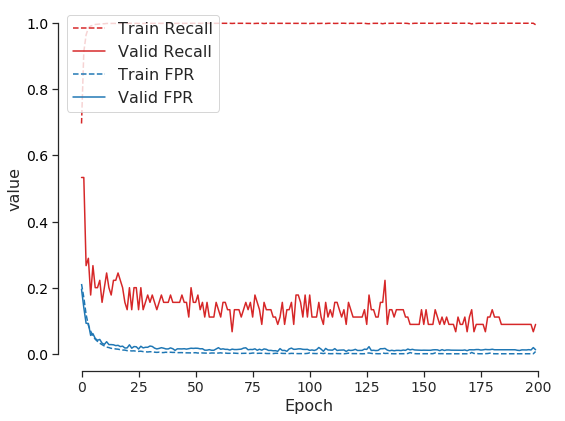

In [ ]:
plt, fig = sp.plot_model_recall_fpr(history)
fig.savefig('mlp_SMOTE_recall_fpr.pdf', bbox_inches='tight')

# Activations

## Model 5.1. SELU.

In [ ]:
model = Sequential()
model.add(Input(shape=(N_FEATURES, )))
model.add(Dense(32, kernel_initializer='lecun_normal', activation='selu'))
model.add(AlphaDropout(0.1))
model.add(Dense(16, kernel_initializer='lecun_normal', activation='selu'))
model.add(AlphaDropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                2240      
_________________________________________________________________
alpha_dropout (AlphaDropout) (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 2,785
Trainable params: 2,785
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 
                     tf.keras.metrics.Recall(),
                     pm.F1Score(),
                     pm.FalsePositiveRate()]
           )

history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=100,
                    validation_data=(X_valid_scaled, y_valid),
                    verbose=0).history

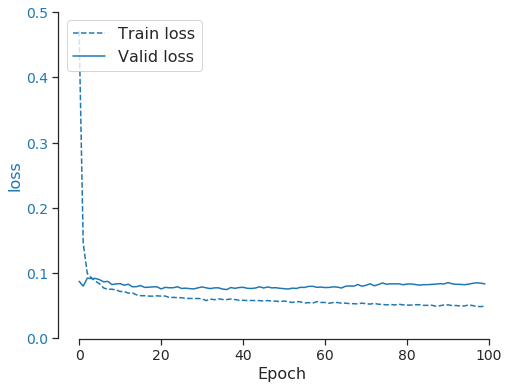

In [ ]:
plt, fig = sp.plot_metric(history, metric='loss')
fig.savefig('mlp_SELU_loss.pdf', bbox_inches='tight')

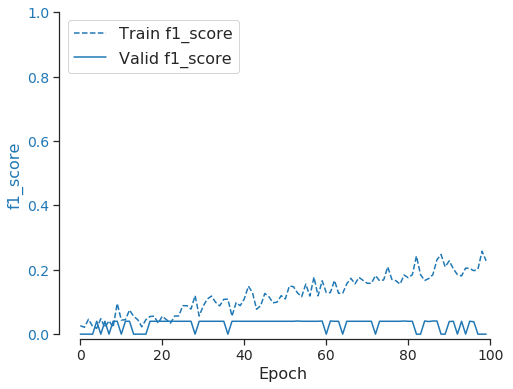

In [ ]:
plt, fig = sp.plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('mlp_SELU_f1score.pdf', bbox_inches='tight')

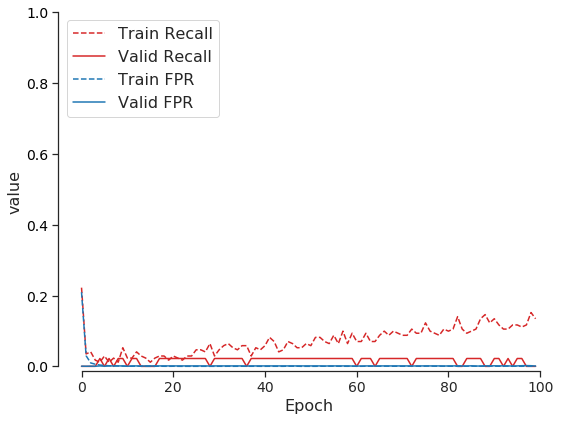

In [ ]:
plt, fig = sp.plot_model_recall_fpr(history)
fig.savefig('mlp_SELU_recall_fpr.pdf', bbox_inches='tight')

## Model 5.2. Custom Activation.

In [ ]:
from tensorflow.keras import backend as K
def telu(x, threshold=0.1):
    '''
    Thresholded Exponential linear unit.
      Arguments:
      x: Input tensor.
      alpha: A scalar = 1.6732632, slope of negative section.
      scale: A scalar = 1.05070098, to keep the gradient > 1 for x > 0.
      Returns:
      The thresholded exponential linear activation: `x` if 
        `scale * x > threshold` and
        `scale * alpha * (exp(x)-1)` if `x < -threshold`.
    '''
    x_ = tf.keras.activations.selu(x)
    
    # Create a tensor of same shape as x with the threshold in each cell.
    threshold_ = tf.math.scalar_mul(threshold, K.ones_like(x_))

    # Creates an identity tensor which is one if the abs(x) > threshold.
    threshold_multiplier = K.cast(tf.keras.backend.less(threshold_, K.abs(x_)), 
                                  dtype='float32')  
    
    return tf.math.multiply(x_, threshold_multiplier)

In [ ]:
test_x = tf.convert_to_tensor([-1., 1.1, 0.01], dtype=tf.float32)
'''Sanity test 1: telu output should be equal to selu if threshold=0.'''
tf.print('TELU with threshold=0.0:', telu(test_x, threshold=0.))
tf.print('SELU for comparison:    ', tf.keras.activations.selu(test_x))

'''Sanity test 2: telu should make activations < threshold. '''
tf.print('TELU default setting:   ', telu(test_x))  # default threshold = 0.1

TELU with threshold=0.0: [-1.11133075 1.15577114 0.0105070099]
SELU for comparison:     [-1.11133075 1.15577114 0.0105070099]
TELU default setting:    [-1.11133075 1.15577114 0]


In [ ]:
model = Sequential()
model.add(Input(shape=(N_FEATURES, )))
model.add(Dense(32, activation=telu))
model.add(Dense(16, activation=telu))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                2240      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 2,785
Trainable params: 2,785
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 
                     tf.keras.metrics.Recall(),
                     pm.F1Score(),
                     pm.FalsePositiveRate()]
           )

history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=100,
                    validation_data=(X_valid_scaled, y_valid),
                    verbose=0).history

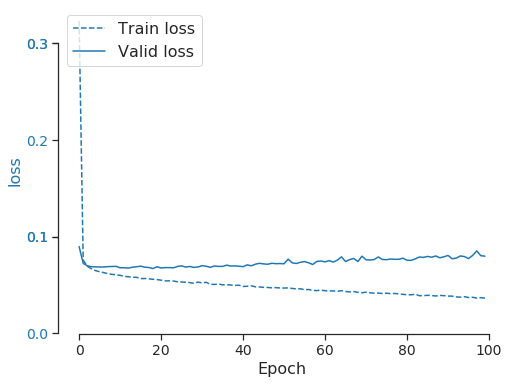

In [ ]:
plt, fig = sp.plot_metric(history, metric='loss')
#fig.savefig('mlp_TELU_loss.pdf', bbox_inches='tight')

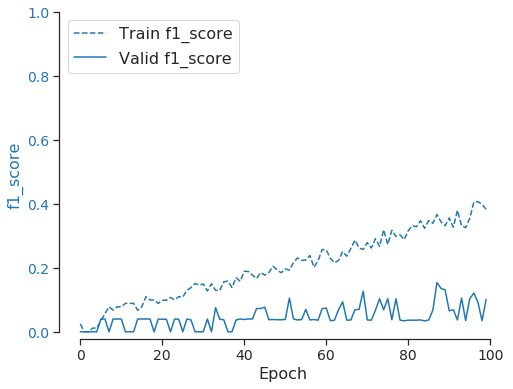

In [ ]:
plt, fig = sp.plot_metric(history, metric='f1_score', ylim=[0., 1.])
#fig.savefig('mlp_TELU_f1score.pdf', bbox_inches='tight')

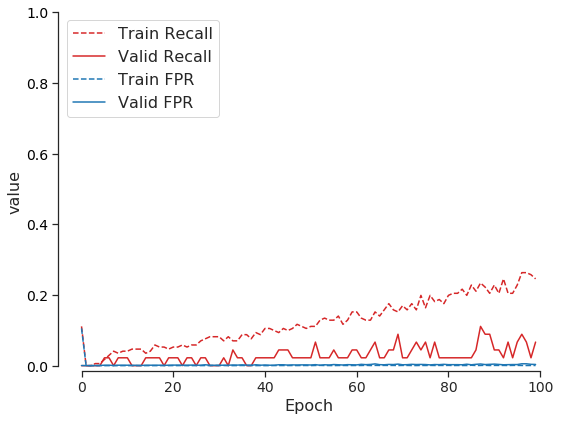

In [ ]:
plt, fig = sp.plot_model_recall_fpr(history)
#fig.savefig('mlp_TELU_recall_fpr.pdf', bbox_inches='tight')

# Final Model

Based on the results, we select Model 5. SELU. The Baseline with `relu` activation is also close to this. 

However, all the other approaches, either,
- made the recall zero, viz. Dropout.
- increased the recall but also the fpr to unacceptable levels, viz. class weights, and oversampling.

We will now evaluate this model on the test data.

In [ ]:
model.evaluate(
            x=X_test_scaled,
            y=y_test,
            batch_size=128,
            verbose=1)

4065/4065 [==============================] - 0s 13us/sample - loss: 0.0713 - accuracy: 0.9860 - recall: 0.0755 - f1_score: 0.1231 - false_positive_rate: 0.0020 


[0.07125760137594934, 0.9859779, 0.0754717, 0.12307692, 0.001994018]